In [1]:
import pymc3 as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sc
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

/Users/Jose.Reyes/.pyenv/versions/3.8.2/envs/jose/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [9]:
data = pd.read_csv("210630COVID19MEXICO.csv")

In [10]:
data_cdmx = data[data["ENTIDAD_RES"]==9]


In [11]:
cases = data_cdmx[data_cdmx["CLASIFICACION_FINAL"]==3]
hosp = cases[cases["TIPO_PACIENTE"]==2]
deaths = cases[cases["FECHA_DEF"]!="9999-99-99"]

In [12]:
cases["counter"]=1
hosp["counter"]=1
deaths["counter"]=1

<ipython-input-12-b91abb484e29>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cases["counter"]=1
<ipython-input-12-b91abb484e29>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hosp["counter"]=1
<ipython-input-12-b91abb484e29>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

In [13]:
def assign_age_group(age):
    if age>=60:
        group = "GRUPO60"
    elif age>=50:
        group = "GRUPO50"
    elif age>=40:
        group = "GRUPO40"
    elif age>=30:
        group = "GRUPO30"
    elif age>=20:
        group = "GRUPO20"
    else:
        group = "GRUPOMENORES"
    
    return group

In [14]:
def build_datasets(df):
    df["grupo"] = df["EDAD"].apply(assign_age_group)
    df["FECHA_SINTOMAS"] = pd.to_datetime(df["FECHA_SINTOMAS"])
    
    ### Aggregating data by day and age group
    df = (df[["FECHA_SINTOMAS","grupo","counter"]]
             .groupby([
                 pd.Grouper(key='FECHA_SINTOMAS', 
                            axis=0,
                            freq='D',
                            sort=True),
                 "grupo"])
             .sum()
             .reset_index())
    df = pd.pivot_table(df,values='counter', 
                   index=['FECHA_SINTOMAS'],
                   columns=['grupo'], 
                   fill_value=0).reset_index()

    df = df.set_index("FECHA_SINTOMAS")
    
    ### Calculating the 7 day rolling mean 
    df = df.rolling(7).mean().dropna()
    #df = df.iloc[0:-2,:]
    
    ### Separating the pre and post intervention periods
    df_all = df[(df.index>="2020-06-01")]
    df_pre = df[(df.index<"2021-02-15") & (df.index>="2020-06-01")]
    df_int = df[(df.index>="2021-02-15") & (df.index<="2021-05-03")]
    
    return df_pre, df_int, df_all

In [15]:
cases_pre, cases_post, cases_all =  build_datasets(cases)
hosp_pre, hosp_post, hosp_all =  build_datasets(hosp)
deaths_pre, deaths_post, deaths_all =  build_datasets(deaths)

<ipython-input-14-7e68b8872af1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["grupo"] = df["EDAD"].apply(assign_age_group)
<ipython-input-14-7e68b8872af1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["FECHA_SINTOMAS"] = pd.to_datetime(df["FECHA_SINTOMAS"])
<ipython-input-14-7e68b8872af1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

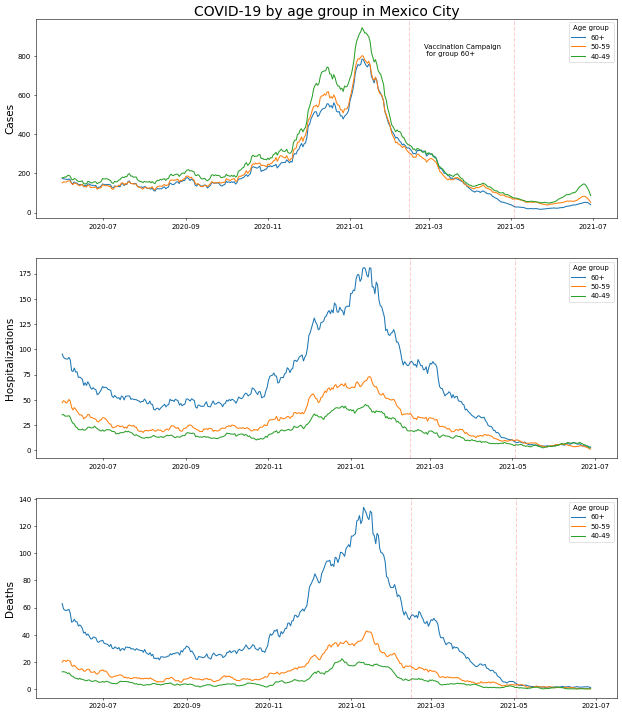

In [9]:
fig, ax = plt.subplots(3,figsize=(15,18),dpi=50)
ax[0].set_title('COVID-19 by age group in Mexico City',fontsize = 20,va='center')
ax[0].plot( cases_all.iloc[(cases_all.index<="2021-07-01"),[4,3,2]])
ax[0].legend( ['60+', '50-59', '40-49'],title= 'Age group',)
ax[0].set_ylabel( 'Cases',size = 15)
ax[0].axvline(pd.to_datetime('2021-02-14'),0,100,color='red', linestyle='--',alpha = 0.2)
ax[0].axvline(pd.to_datetime('2021-05-03'),0,100,color='red', linestyle='--',alpha = 0.2)
ax[0].text(pd.to_datetime('2021-02-25'),800,"Vaccination Campaign \n for group 60+")


ax[1].plot( hosp_all.iloc[(hosp_all.index<="2021-07-01"),[4,3,2]], label=['60+', '50-59', '40-49'])
ax[1].legend(['60+', '50-59', '40-49'],title= 'Age group')
ax[1].set_ylabel('Hospitalizations',size = 15)
ax[1].axvline(pd.to_datetime('2021-02-14'),0,180,color='red', linestyle='--',alpha = 0.2)
ax[1].axvline(pd.to_datetime('2021-05-03'),0,180,color='red', linestyle='--',alpha = 0.2)

ax[2].plot( deaths_all.iloc[(deaths_all.index<="2021-07-01"),[4,3,2]], label=['60+', '50-59', '40-49'])
ax[2].set_ylabel('Deaths',size = 15)
ax[2].legend(['60+', '50-59', '40-49'],title= 'Age group')
ax[2].axvline(pd.to_datetime('2021-02-14'),0,180,color='red', linestyle='--',alpha = 0.2)
ax[2].axvline(pd.to_datetime('2021-05-03'),0,180,color='red', linestyle='--',alpha = 0.2)

fig.savefig("images/covid_cdmx.png")


In [16]:
scaler_cases = StandardScaler().fit(cases_pre[["GRUPO60","GRUPO50","GRUPO40"]])
scaler_hosp = StandardScaler().fit(hosp_pre[["GRUPO60","GRUPO50","GRUPO40"]])
scaler_deaths = StandardScaler().fit(deaths_pre[["GRUPO60","GRUPO50","GRUPO40"]])

In [17]:
cases_new = cases_all.copy()
cases_new.iloc[cases_new.index>pd.to_datetime("2021-02-14"),-2]=np.nan
cases_new

grupo,GRUPO20,GRUPO30,GRUPO40,GRUPO50,GRUPO60,GRUPOMENORES
FECHA_SINTOMAS,,,,,,
2020-06-01,105.142857,182.428571,176.857143,151.857143,175.714286,36.285714
2020-06-02,108.000000,182.857143,178.142857,156.285714,172.000000,35.142857
2020-06-03,106.428571,182.285714,182.000000,155.857143,171.857143,34.285714
2020-06-04,106.714286,181.285714,181.428571,155.857143,169.285714,31.428571
2020-06-05,111.142857,189.571429,188.857143,160.142857,167.857143,32.142857
...,...,...,...,...,...,...
2021-06-25,211.285714,185.285714,143.000000,81.714286,NaN,119.571429
2021-06-26,202.714286,180.857143,133.142857,77.000000,NaN,121.000000
2021-06-27,185.714286,167.714286,121.000000,70.571429,NaN,111.000000


In [12]:
hosp_new = hosp_all.copy()
hosp_new.iloc[hosp_new.index>pd.to_datetime("2021-02-14"),-2]=np.nan
hosp_new

grupo,GRUPO20,GRUPO30,GRUPO40,GRUPO50,GRUPO60,GRUPOMENORES
FECHA_SINTOMAS,,,,,,
2020-06-01,5.285714,19.571429,35.000000,47.000000,95.285714,3.285714
2020-06-02,4.857143,20.428571,35.428571,49.142857,92.142857,2.857143
2020-06-03,4.285714,20.571429,33.857143,48.285714,90.857143,3.142857
2020-06-04,4.428571,20.142857,33.857143,46.714286,90.428571,3.142857
2020-06-05,4.571429,21.428571,33.714286,48.000000,90.285714,3.142857
...,...,...,...,...,...,...
2021-06-24,1.428571,2.714286,5.285714,3.428571,NaN,0.857143
2021-06-25,1.000000,2.571429,4.142857,2.857143,NaN,0.857143
2021-06-26,0.857143,2.142857,3.714286,2.428571,NaN,0.571429


In [18]:
deaths_new = deaths_all.copy()
deaths_new.iloc[deaths_new.index>pd.to_datetime("2021-02-14"),-2]=np.nan
deaths_new

grupo,GRUPO20,GRUPO30,GRUPO40,GRUPO50,GRUPO60,GRUPOMENORES
FECHA_SINTOMAS,,,,,,
2020-06-01,0.857143,4.428571,12.857143,20.000000,63.000000,0.000000
2020-06-02,0.714286,4.285714,12.857143,21.142857,59.000000,0.000000
2020-06-03,0.857143,4.000000,12.714286,21.000000,58.142857,0.142857
2020-06-04,1.000000,3.714286,12.285714,20.428571,57.857143,0.142857
2020-06-05,0.857143,4.142857,11.571429,21.285714,58.285714,0.142857
...,...,...,...,...,...,...
2021-06-18,0.428571,0.142857,0.285714,0.714286,NaN,0.000000
2021-06-20,0.285714,0.142857,0.428571,0.571429,NaN,0.000000
2021-06-23,0.285714,0.142857,0.285714,0.428571,NaN,0.000000


In [19]:
cases_pre_scaled = scaler_cases.transform(cases_new[["GRUPO60","GRUPO50","GRUPO40"]])
y_cases = cases_pre_scaled[:,0]
x1_cases = cases_pre_scaled[:,1]
x2_cases = cases_pre_scaled[:,2]

In [20]:
hosp_pre_scaled = scaler_hosp.transform(hosp_new[["GRUPO60","GRUPO50","GRUPO40"]])
y_hosp = hosp_pre_scaled[:,0]
x1_hosp = hosp_pre_scaled[:,1]
x2_hosp = hosp_pre_scaled[:,2]

NameError: name 'hosp_new' is not defined

In [ ]:
deaths_pre_scaled = scaler_deaths.transform(deaths_new[["GRUPO60","GRUPO50","GRUPO40"]])
y_deaths = deaths_pre_scaled[:,0]
x1_deaths = deaths_pre_scaled[:,1]
x2_deaths = deaths_pre_scaled[:,2]

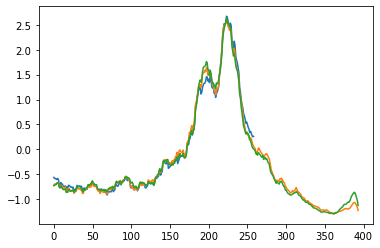

In [17]:
plt.plot(y_cases)
plt.plot(x1_cases)
plt.plot(x2_cases)

In [18]:
def model_1(y_obs,x1_data,x2_data):
    
    inter = np.where(cases_all.index =='2021-02-14')[0][0]
    #Seting hyperparams
    sample_size = len(y_obs[0:inter])
    sigma_guess = 0.01
    df = sample_size
    a_a = np.float32(df / 2)
    ss = sample_size * sigma_guess ** 2
    b_a = np.float32(ss / 2)


    sd_obs = np.std(y_obs[0:inter])
    a_y = a_a
    b_y = np.float32(sd_obs / 2)
    
    xtx = np.array([x1_data[0:inter],x2_data[0:inter]])@np.array([x1_data[0:inter],x2_data[0:inter]]).T
    w = .5
    g = 1
    n = len(x1_data[0:inter])
    mat = (g/n)*((w*xtx) + (1-w)*np.diag(xtx))
    mat_inv = np.linalg.inv(mat)
    
    with pm.Model() as model:
        x1 = pm.Data("x1",x1_data)
        x2 = pm.Data("x2",x2_data)


        tau_a = pm.Gamma("tau_a",alpha = a_a, beta = b_a)
        tau_y = pm.Gamma("tau_y",alpha = a_y, beta = b_y)

        sigma_b = pm.Gamma("sigma_b",alpha = 200, beta = .1)

        beta = pm.MvNormal("beta",mu = [0.5,0.5], cov = (sigma_b**(-1)*mat_inv),shape=2)

        #beta1 = pm.Normal('beta1',mu = 1.18 ,sigma = 2, testval=1.1849,shape = 1)
        #beta2 = pm.Normal('beta2',mu = -.18,sigma = 2, testval = -0.1887,shape = 1)


        a = pm.GaussianRandomWalk("a",tau = tau_a, shape = len(y_obs))
        reg = pm.Deterministic("reg",beta[0]*x1+beta[1]*x2)

        mu_y = pm.Deterministic("mu_y",a+reg)

        y = pm.Normal("y", mu = mu_y, tau = tau_y, observed = y_obs)
    
    return model


In [19]:
def train_model(model):
    with model:
        start = pm.find_MAP(model=model)
        step = pm.NUTS(target_accept = .9)
        trace = pm.sample(draws= 5000, tune=1000, start = start, step = step, progressbar=True) 
        burned_trace = trace[1500:]
        ppc = pm.sample_posterior_predictive(burned_trace, samples=28000)
        idata_pymc3 = az.from_pymc3(
            trace=burned_trace,
            posterior_predictive=ppc,
        )
    return idata_pymc3

In [20]:
model1_cases = model_1(y_cases,x1_cases,x2_cases)
model1_hosp = model_1(y_hosp,x1_hosp,x2_hosp)
model1_deaths = model_1(y_deaths,x1_deaths,x2_deaths)

/Users/Jose.Reyes/opt/anaconda3/lib/python3.8/site-packages/pymc3/model.py:1755: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/Jose.Reyes/opt/anaconda3/lib/python3.8/site-packages/pymc3/model.py:1755: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


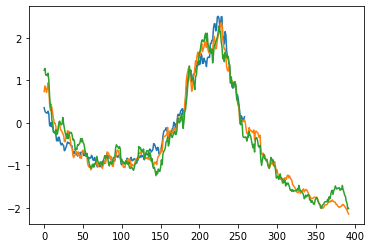

In [21]:
plt.plot(y_hosp)
plt.plot(x1_hosp)
plt.plot(x2_hosp)

In [22]:
cases_trace = train_model(model1_cases)

<ipython-input-19-6479124ac243>:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws= 5000, tune=1000, start = start, step = step, progressbar=True)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_missing, a, beta, sigma_b, tau_y, tau_a]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 1810 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


In [23]:
hosp_trace = train_model(model1_hosp)

<ipython-input-19-6479124ac243>:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws= 5000, tune=1000, start = start, step = step, progressbar=True)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_missing, a, beta, sigma_b, tau_y, tau_a]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 1561 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


In [24]:
deaths_trace = train_model(model1_deaths)

<ipython-input-19-6479124ac243>:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws= 5000, tune=1000, start = start, step = step, progressbar=True)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_missing, a, beta, sigma_b, tau_y, tau_a]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 1181 seconds.
The number of effective samples is smaller than 10% for some parameters.


posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


In [25]:
import pickle

file_to_store = open("models_cases_hosp_deaths.pickle", "wb")
pickle.dump([cases_trace,hosp_trace,deaths_trace], file_to_store) 

In [4]:
import pickle

file_to_store = open("models_cases_hosp_deaths.pickle", "rb")
cases_trace,hosp_trace,deaths_trace = pickle.load(file_to_store) 

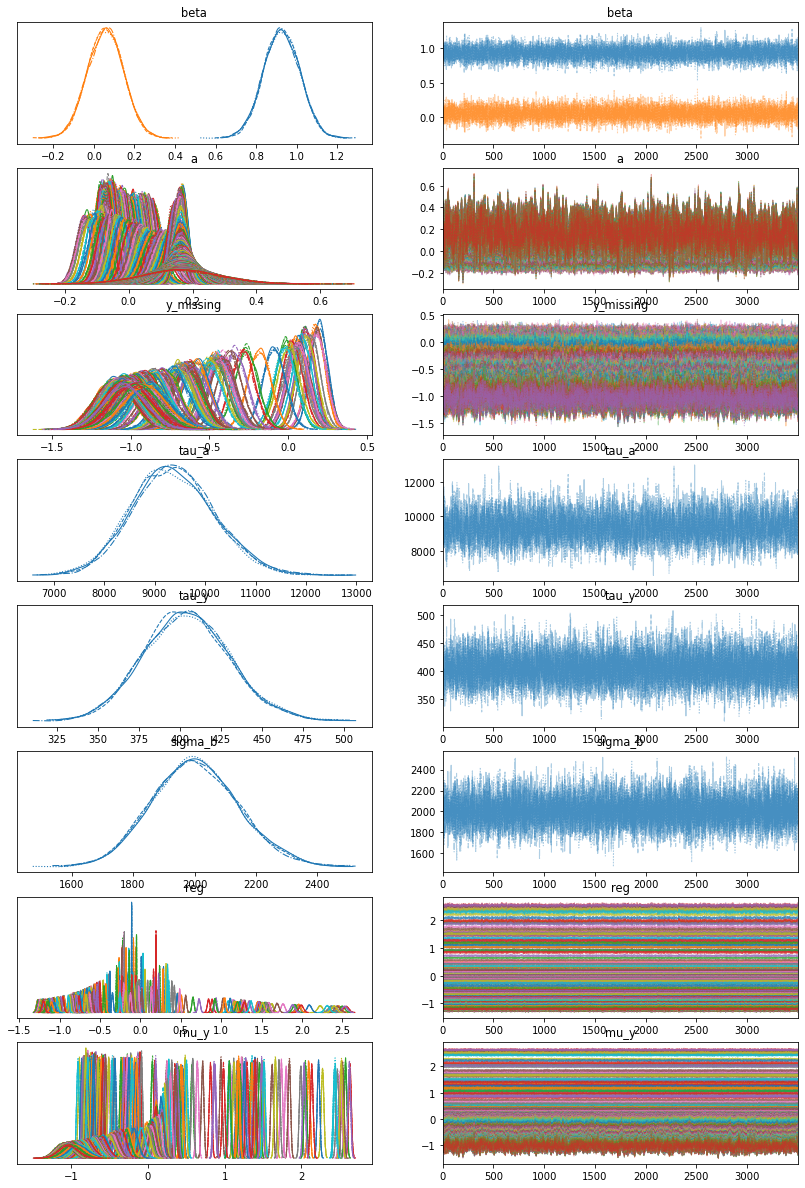

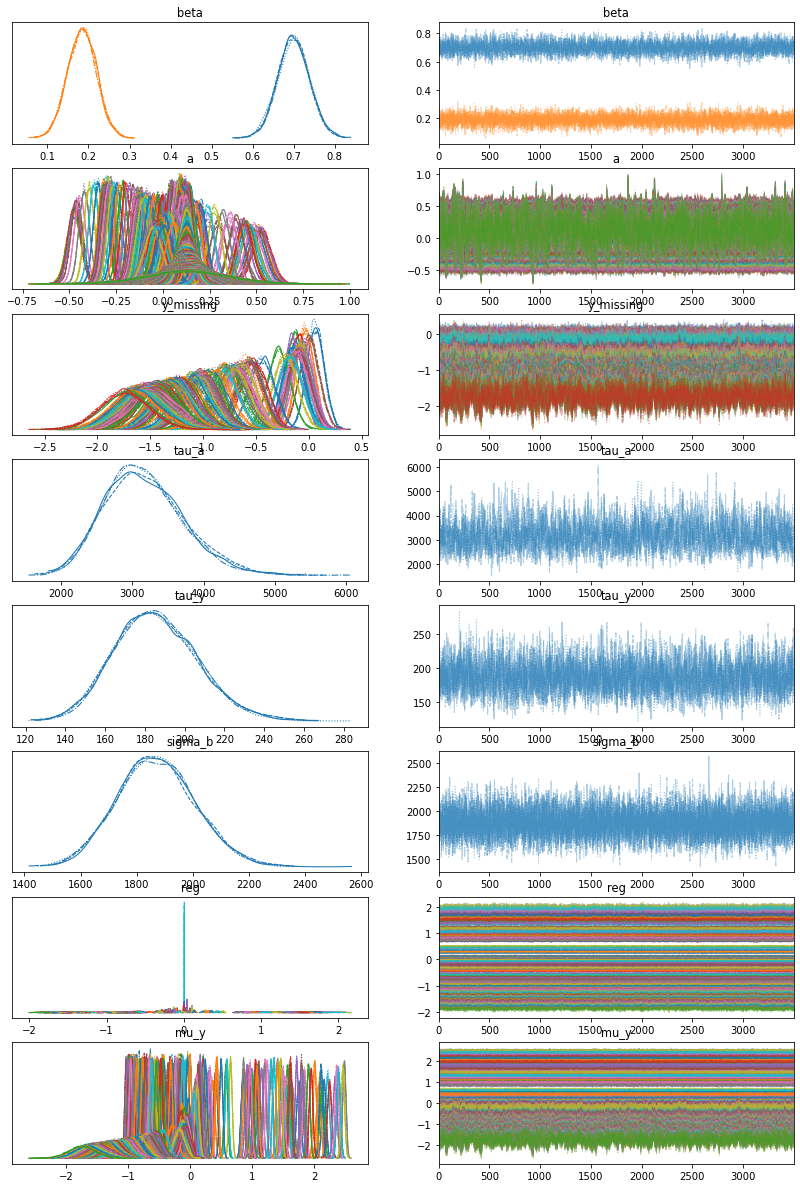

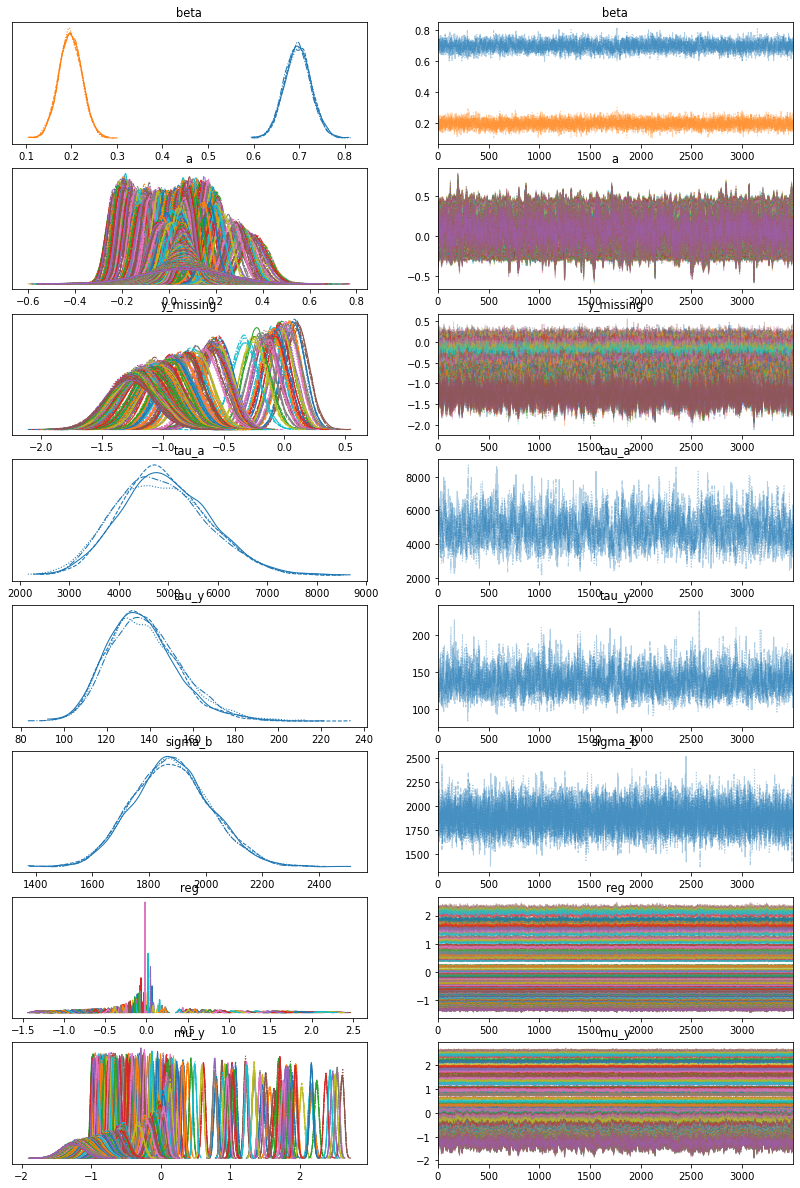

In [107]:
trace1 = az.plot_trace(cases_trace,figsize=(14,7*3))
trace2 = az.plot_trace(hosp_trace,figsize=(14,7*3))
trace3 = az.plot_trace(deaths_trace,figsize=(14,7*3))

In [108]:
fig = trace1.ravel()[0].figure
fig.savefig("images/trace_cases.png")
fig = trace2.ravel()[0].figure
fig.savefig("images/trace_hosp.png")
fig = trace3.ravel()[0].figure
fig.savefig("images/trace_deaths.png")

In [109]:
summary1 = az.summary(cases_trace)
summary2 = az.summary(hosp_trace)
summary3 = az.summary(deaths_trace)

In [6]:
c1,c2 = np.percentile(cases_trace.posterior_predictive.y[0,0:20000,:].T,[3,97],axis=1)*188.09119341+281.97297297
h1,h2 = np.percentile(hosp_trace.posterior_predictive.y[0,0:20000,:].T,[3,97],axis=1)*39.80921204+81.2956425
d1,d2 = np.percentile(deaths_trace.posterior_predictive.y[0,0:20000,:].T,[3,97],axis=1)*30.99467157+51.6210700

In [7]:
cases_all.shape

NameError: name 'cases_all' is not defined

In [112]:
ini = np.where(cases_all.index =='2021-02-15')[0][0]
end = np.where(cases_all.index =='2021-05-03')[0][0]+1

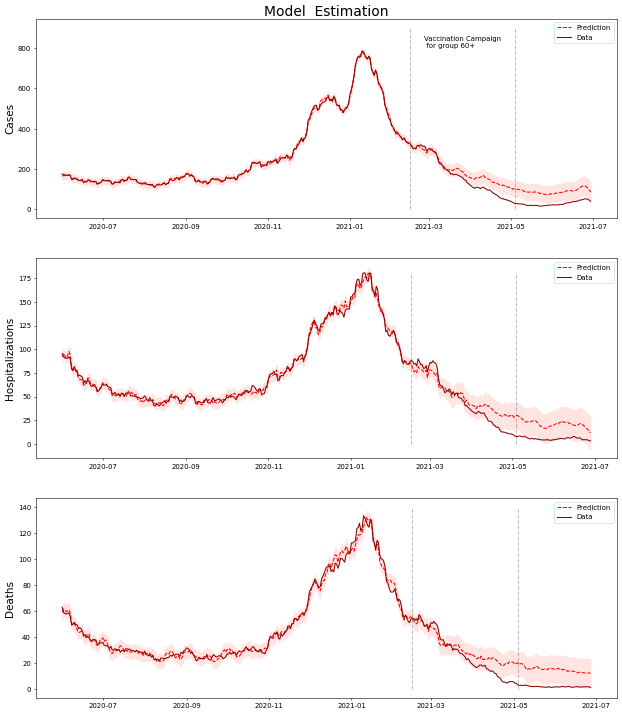

In [191]:
fig, ax = plt.subplots(3,figsize=(15,18),dpi=50)
ax[0].set_title('Model  Estimation',fontsize = 20,va='center')
ax[0].fill_between(cases_all.index,y1=c1,y2=c2,color="mistyrose")
ax[0].plot(cases_all.index,np.mean(cases_trace.posterior_predictive.y[0,0:5000,:].T,axis=1)*188.09119341+281.97297297,"--",color="red",label="Prediction")
ax[0].plot(cases_all.index,cases_all.GRUPO60,color="darkred",label="Data")
ax[0].vlines(cases_all.index[ini],0,900,linestyle="dashed",color="grey",alpha=0.5)
ax[0].vlines(cases_all.index[end],0,900,linestyle="dashed",color="grey",alpha=0.5)
ax[0].text(pd.to_datetime('2021-02-25'),800,"Vaccination Campaign \n for group 60+")
ax[0].legend()
ax[0].set_ylabel("Cases",size=15)

ax[1].fill_between(hosp_all.index,y1=h1,y2=h2,color="mistyrose")
ax[1].plot(hosp_all.index,np.mean(hosp_trace.posterior_predictive.y[0,0:5000,:].T,axis=1)*39.80921204+81.2956425,"--",color="red",label="Prediction")
ax[1].plot(hosp_all.index,hosp_all.GRUPO60,color="darkred",label="Data")

ax[1].vlines(cases_all.index[ini],0,180,linestyle="dashed",color="grey",alpha=0.5)
ax[1].vlines(cases_all.index[end],0,180,linestyle="dashed",color="grey",alpha=0.5)

ax[1].legend()
ax[1].set_ylabel("Hospitalizations",size=15)

ax[2].fill_between(deaths_all.index,y1=d1,y2=d2,color="mistyrose")
ax[2].plot(deaths_all.index,np.mean(deaths_trace.posterior_predictive.y[0,0:5000,:].T,axis=1)*30.99467157+51.6210700,"--",color="red",label="Prediction")
ax[2].plot(deaths_all.index,deaths_all.GRUPO60,color="darkred",label="Data")
ax[2].vlines(cases_all.index[ini],0,140,linestyle="dashed",color="grey",alpha=0.5)
ax[2].vlines(cases_all.index[end],0,140,linestyle="dashed",color="grey",alpha=0.5)

ax[2].legend()
ax[2].set_ylabel("Deaths",size=15)

fig.savefig("images/prefit.png")

## Cumulative Effect

In [21]:
ini = np.where(cases_all.index =='2021-02-15')[0][0]
end = np.where(cases_all.index =='2021-05-03')[0][0]+1

In [22]:
point_sim_cases= []
cum_sum_cases = []
for j in range(0,28000):
    y_pred = cases_trace.posterior_predictive.y[0,j,ini:end].T*188.09119341+281.97297297
    y = np.array(cases_all.iloc[ini:end,-2])
    point= y- y_pred
    cum = np.cumsum(point)
    point_sim_cases.append(point)
    cum_sum_cases.append(cum)
    

In [23]:
point_sim_hosp= []
cum_sum_hosp = []
for j in range(0,28000):
    y_pred = hosp_trace.posterior_predictive.y[0,j,ini:end].T*39.80921204+81.2956425
    y = np.array(hosp_all.iloc[ini:end,-2])
    point= y- y_pred
    cum = np.cumsum(point)
    point_sim_hosp.append(point)
    cum_sum_hosp.append(cum)

In [24]:
point_sim_deaths= []
cum_sum_deaths = []
for j in range(0,28000):
    y_pred = deaths_trace.posterior_predictive.y[0,j,ini:end].T*30.99467157+51.6210700
    y = np.array(deaths_all.iloc[ini:end,-2])
    point= y- y_pred
    cum = np.cumsum(point)
    point_sim_deaths.append(point)
    cum_sum_deaths.append(cum)

In [25]:
cum_sum_deaths = np.array(cum_sum_deaths)
cum_sum_hosp = np.array(cum_sum_hosp)
cum_sum_cases = np.array(cum_sum_cases)

In [26]:
point_sim_deaths = np.array(point_sim_deaths)
point_sim_hosp = np.array(point_sim_hosp)
point_sim_cases = np.array(point_sim_cases)

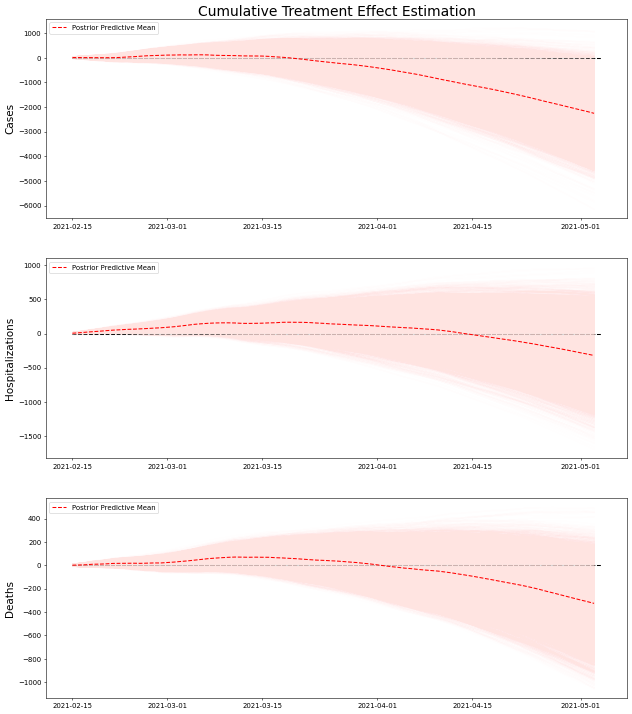

In [120]:
fig, ax = plt.subplots(3,figsize=(15,18),dpi=50)

ax[0].set_title('Cumulative Treatment Effect Estimation',fontsize = 20,va='center')
ax[0].plot(cases_all.index[ini:end],cum_sum_cases.T,color="mistyrose",alpha = 0.02)
ax[0].plot(cases_all.index[ini:end],np.mean(cum_sum_cases.T,axis=1),"--",color="red",label="Postrior Predictive Mean")
ax[0].hlines(0,cases_all.index[ini],cases_all.index[end],linestyles = "dashed", color="black")
ax[0].legend()
ax[0].set_ylabel("Cases",size=15)


ax[1].plot(hosp_all.index[ini:end],cum_sum_hosp.T,color="mistyrose",alpha = 0.02)
ax[1].plot(hosp_all.index[ini:end],np.mean(cum_sum_hosp.T,axis=1),"--",color="red",label="Postrior Predictive Mean")
ax[1].hlines(0,cases_all.index[ini],cases_all.index[end],linestyles = "dashed", color="black")
ax[1].legend()
ax[1].set_ylabel("Hospitalizations",size=15)


ax[2].plot(deaths_all.index[ini:end],cum_sum_deaths.T,color="mistyrose",alpha = 0.02)
ax[2].plot(deaths_all.index[ini:end],np.mean(cum_sum_deaths.T,axis=1),"--",color="red",label="Postrior Predictive Mean")
ax[2].hlines(0,cases_all.index[ini],cases_all.index[end],linestyles = "dashed", color="black")
ax[2].legend()
ax[2].set_ylabel("Deaths",size=15)

fig.savefig("images/cum_Effect.png")

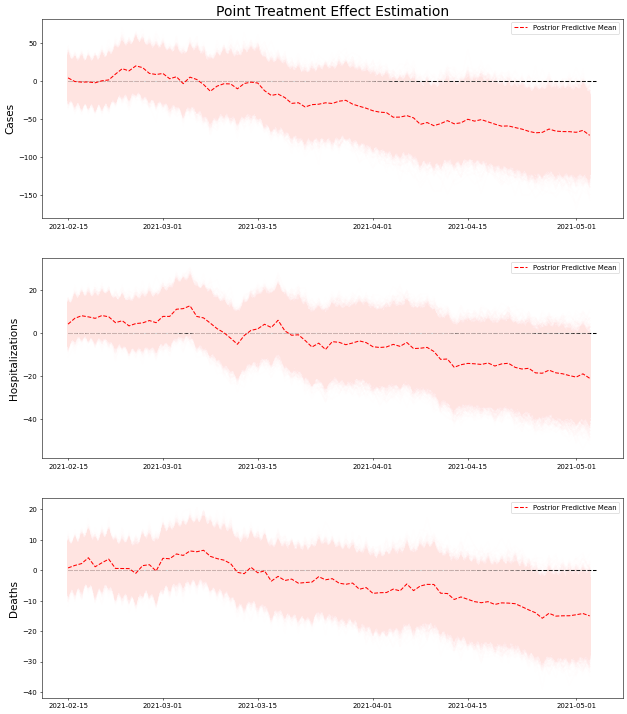

In [121]:
fig, ax = plt.subplots(3,figsize=(15,18),dpi=50)

ax[0].set_title('Point Treatment Effect Estimation',fontsize = 20,va='center')

ax[0].plot(cases_all.index[ini:end],point_sim_cases.T,color="mistyrose",alpha = 0.02)
ax[0].hlines(0,cases_all.index[ini],cases_all.index[end],linestyles = "dashed", color="black")
ax[0].plot(cases_all.index[ini:end],np.mean(point_sim_cases.T,axis=1),"--",color="red",label="Postrior Predictive Mean")
ax[0].legend()
ax[0].set_ylabel("Cases",size=15)


ax[1].plot(hosp_all.index[ini:end],point_sim_hosp.T,color="mistyrose",alpha = 0.02)
ax[1].hlines(0,cases_all.index[ini],cases_all.index[end],linestyles = "dashed", color="black")
ax[1].plot(hosp_all.index[ini:end],np.mean(point_sim_hosp.T,axis=1),"--",color="red",label="Postrior Predictive Mean")

ax[1].legend()
ax[1].set_ylabel("Hospitalizations",size=15)


ax[2].plot(deaths_all.index[ini:end],point_sim_deaths.T,color="mistyrose",alpha = 0.02)
ax[2].hlines(0,cases_all.index[ini],cases_all.index[end],linestyles = "dashed", color="black")
ax[2].plot(deaths_all.index[ini:end],np.mean(point_sim_deaths.T,axis=1),"--",color="red",label="Postrior Predictive Mean")

ax[2].legend()
ax[2].set_ylabel("Deaths",size=15)

fig.savefig("images/point_Effect.png")

## Pvalue

In [27]:
print(1-sum(cum_sum_cases[:,-1]<0)/cum_sum_cases.shape[0])
print(1-sum(cum_sum_hosp[:,-1]<0)/cum_sum_hosp.shape[0])
print(1-sum(cum_sum_deaths[:,-1]<0)/cum_sum_deaths.shape[0])



0.003607142857142809
0.15142857142857147
0.04985714285714282


# cumulative effect 

In [28]:
np.percentile(cum_sum_cases[:,-1],[2.5,97.5])

array([-3957.62625844,  -561.84070472])

In [29]:
np.mean(cum_sum_cases[:,-1])

-2257.26657323101

In [30]:
np.percentile(cum_sum_hosp[:,-1],[2.5,97.5])

array([-958.45484416,  312.90145058])

In [126]:
np.mean(cum_sum_hosp[:,-1])

-322.5908115541607

In [31]:
np.percentile(cum_sum_deaths[:,-1],[2.5,97.5])

array([-720.72389558,   60.85962417])

In [128]:
np.mean(cum_sum_deaths[:,-1])

-326.21523549940105

## Relative cumulative effect 

In [32]:
np.percentile(cum_sum_cases[:,-1],[2.5,97.5])/np.cumsum(cases_post.GRUPO60)[-1]

array([-0.30004748, -0.04259596])

In [130]:
np.mean(cum_sum_cases[:,-1])/np.cumsum(cases_post.GRUPO60)[-1]

-0.17113469091971267

In [33]:
np.percentile(cum_sum_hosp[:,-1],[2.5,97.5])/np.cumsum(hosp_post.GRUPO60)[-1]

array([-0.26061156,  0.08508041])

In [132]:
np.mean(cum_sum_hosp[:,-1])/np.cumsum(hosp_post.GRUPO60)[-1]

-0.08771502800183051

In [34]:
np.percentile(cum_sum_deaths[:,-1],[2.5,97.5])/np.cumsum(hosp_post.GRUPO60)[-1]

array([-0.19597061,  0.01654822])

In [134]:
np.mean(cum_sum_deaths[:,-1])/np.cumsum(deaths_post.GRUPO60)[-1]

-0.15068672617763015

## Reltive Average Effect

In [35]:
np.percentile(np.mean(point_sim_cases,axis=1),[2.5,97.5])/np.mean(cases_post.GRUPO60)

array([-0.30004748, -0.04259596])

In [36]:
np.percentile(np.mean(point_sim_hosp,axis=1),[2.5,97.5])/np.mean(hosp_post.GRUPO60)

array([-0.26061156,  0.08508041])

In [37]:
np.percentile(np.mean(point_sim_deaths,axis=1),[2.5,97.5])/np.mean(deaths_post.GRUPO60)

array([-0.33291984,  0.02811254])

## Average Efffect

In [38]:
np.percentile(np.mean(point_sim_cases,axis=1),[2.5,97.5])

array([-50.73879819,  -7.20308596])

In [139]:
np.mean(np.mean(point_sim_cases,axis=1))

-28.939315041423207

In [39]:
np.percentile(np.mean(point_sim_hosp,axis=1),[2.5,97.5])

array([-12.28788262,   4.01155706])

In [141]:
np.mean(np.mean(point_sim_hosp,axis=1))

-4.135779635309753

In [40]:
np.percentile(np.mean(point_sim_deaths,axis=1),[2.5,97.5])

array([-9.24004994,  0.78025159])

In [143]:
np.mean(np.mean(point_sim_deaths,axis=1))

-4.18224660896668

In [203]:
np.mean(cases_trace.posterior_predictive.stack(sample=("chain", "draw"))["y"].values[259:259+79].T*188.09119341+281.97297297)

196.81946182406602

In [206]:
np.mean(hosp_trace.posterior_predictive.stack(sample=("chain", "draw"))["y"].values[259:259+79].T*39.80921204+81.2956425)

51.01649318093732

In [207]:
np.mean(deaths_trace.posterior_predictive.stack(sample=("chain", "draw"))["y"].values[259:259+79].T*30.99467157+51.6210700)

31.787794980900596

In [41]:
np.percentile(np.mean(cases_trace.posterior_predictive.stack(sample=("chain", "draw"))["y"].values[259:259+79].T*188.09119341+281.97297297,axis=1),[2.5,97.5])

array([174.94961409, 218.72689415])

In [42]:
np.percentile(np.mean(hosp_trace.posterior_predictive.stack(sample=("chain", "draw"))["y"].values[259:259+79].T*39.80921204+81.2956425,axis=1),[2.5,97.5])

array([42.82056056, 59.19079534])

In [43]:
np.percentile(np.mean(deaths_trace.posterior_predictive.stack(sample=("chain", "draw"))["y"].values[259:259+79].T*30.99467157+51.6210700,axis=1),[2.5,97.5])

array([26.79297837, 36.86106381])

In [196]:
cases_post.GRUPO60.mean()

169.10256410256412

In [197]:
hosp_post.GRUPO60.mean()

47.15018315018316

In [198]:
deaths_post.GRUPO60.mean()

27.754578754578752

In [144]:
f = open("models_cases_hosp_deaths_lag.pickle","rb") 
models_lag = pickle.load(f)

In [146]:
compare_dict = {"normal": cases_trace, "lag": models_lag[0]}

In [147]:
y_true = cases_trace.observed_data["y"].values[0:259]
y_pred = cases_trace.posterior_predictive.stack(sample=("chain", "draw"))["y"].values[0:259].T
az.r2_score(y_true, y_pred)

r2        0.997250
r2_std    0.000036
dtype: float64

In [148]:
y_true = hosp_trace.observed_data["y"].values[0:259]
y_pred = hosp_trace.posterior_predictive.stack(sample=("chain", "draw"))["y"].values[0:259].T
az.r2_score(y_true, y_pred)

r2        0.993789
r2_std    0.000131
dtype: float64

In [149]:
y_true = deaths_trace.observed_data["y"].values[0:259]
y_pred = deaths_trace.posterior_predictive.stack(sample=("chain", "draw"))["y"].values[0:259].T
az.r2_score(y_true, y_pred)

r2        0.991872
r2_std    0.000188
dtype: float64

In [181]:
np.percentile(
np.sum(
    np.abs(
        np.array(cases_trace.posterior_predictive.stack(sample=("chain", "draw"))["y"].values[0:259].T-cases_trace.observed_data["y"].values[0:259]))
    ,axis=1),[2.5,97.5])

array([11.02327372, 13.62298566])

In [180]:
np.percentile(
np.sum(
    np.abs(
        np.array(models_lag[0].posterior_predictive.stack(sample=("chain", "draw"))["y"].values[0:259].T-models_lag[0].observed_data["y"].values[0:259]))
    ,axis=1),[2.5,97.5])

array([15.91187378, 19.24157518])

In [182]:
np.percentile(
np.sum(
    np.abs(
        np.array(hosp_trace.posterior_predictive.stack(sample=("chain", "draw"))["y"].values[0:259].T-hosp_trace.observed_data["y"].values[0:259]))
    ,axis=1),[2.5,97.5])

array([19.66258431, 26.3583742 ])

In [183]:
np.percentile(
np.sum(
    np.abs(
        np.array(models_lag[1].posterior_predictive.stack(sample=("chain", "draw"))["y"].values[0:259].T-models_lag[1].observed_data["y"].values[0:259]))
    ,axis=1),[2.5,97.5])

array([29.91749101, 37.02834339])

In [185]:
np.percentile(
np.sum(
    np.abs(
        np.array(deaths_trace.posterior_predictive.stack(sample=("chain", "draw"))["y"].values[0:259].T-deaths_trace.observed_data["y"].values[0:259]))
    ,axis=1),[2.5,97.5])

array([23.61180906, 31.50819496])

In [184]:
np.percentile(
np.sum(
    np.abs(
        np.array(models_lag[2].posterior_predictive.stack(sample=("chain", "draw"))["y"].values[0:259].T-models_lag[2].observed_data["y"].values[0:259]))
    ,axis=1),[2.5,97.5])

array([29.14185324, 35.74587196])

(array([3.800e+01, 4.260e+02, 2.468e+03, 6.609e+03, 9.080e+03, 6.375e+03,
        2.430e+03, 5.120e+02, 5.500e+01, 7.000e+00]),
 array([26.08148713, 27.48214937, 28.88281162, 30.28347386, 31.68413611,
        33.08479835, 34.48546059, 35.88612284, 37.28678508, 38.68744733,
        40.08810957]),
 <BarContainer object of 10 artists>)

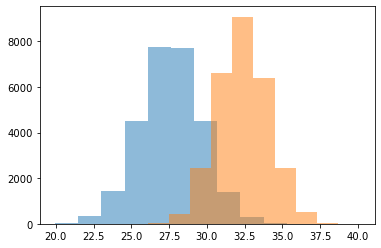

(array([2.300e+01, 3.410e+02, 2.304e+03, 6.469e+03, 9.065e+03, 6.501e+03,
        2.553e+03, 6.550e+02, 8.100e+01, 8.000e+00]),
 array([14.31589453, 15.01612494, 15.71635535, 16.41658575, 17.11681616,
        17.81704657, 18.51727697, 19.21750738, 19.91773779, 20.61796819,
        21.3181986 ]),
 <BarContainer object of 10 artists>)

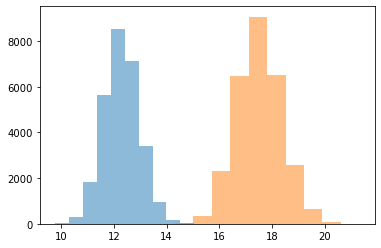

In [188]:
plt.hist(np.sum(
    np.abs(
        np.array(cases_trace.posterior_predictive.stack(sample=("chain", "draw"))["y"].values[0:259].T-cases_trace.observed_data["y"].values[0:259]))
    ,axis=1),alpha=0.5)
plt.hist(np.sum(
    np.abs(
        np.array(models_lag[0].posterior_predictive.stack(sample=("chain", "draw"))["y"].values[0:259].T-models_lag[0].observed_data["y"].values[0:259]))
    ,axis=1),alpha=0.5)

(array([  18.,  154., 1226., 4726., 8891., 7956., 3833., 1034.,  149.,
          13.]),
 array([25.91905901, 27.43988685, 28.96071469, 30.48154253, 32.00237036,
        33.5231982 , 35.04402604, 36.56485388, 38.08568172, 39.60650956,
        41.1273374 ]),
 <BarContainer object of 10 artists>)

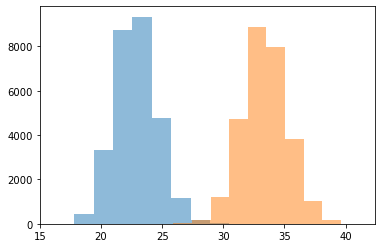

In [190]:
plt.hist(np.sum(
    np.abs(
        np.array(hosp_trace.posterior_predictive.stack(sample=("chain", "draw"))["y"].values[0:259].T-hosp_trace.observed_data["y"].values[0:259]))
    ,axis=1),alpha=0.5)
plt.hist(np.sum(
    np.abs(
        np.array(models_lag[1].posterior_predictive.stack(sample=("chain", "draw"))["y"].values[0:259].T-models_lag[1].observed_data["y"].values[0:259]))
    ,axis=1),alpha=0.5)

(array([3.800e+01, 4.260e+02, 2.468e+03, 6.609e+03, 9.080e+03, 6.375e+03,
        2.430e+03, 5.120e+02, 5.500e+01, 7.000e+00]),
 array([26.08148713, 27.48214937, 28.88281162, 30.28347386, 31.68413611,
        33.08479835, 34.48546059, 35.88612284, 37.28678508, 38.68744733,
        40.08810957]),
 <BarContainer object of 10 artists>)

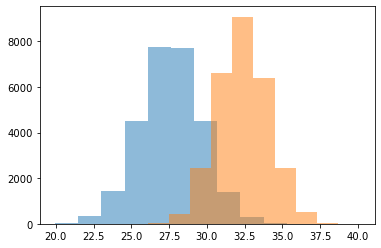

In [189]:
plt.hist(np.sum(
    np.abs(
        np.array(deaths_trace.posterior_predictive.stack(sample=("chain", "draw"))["y"].values[0:259].T-deaths_trace.observed_data["y"].values[0:259]))
    ,axis=1),alpha=0.5)
plt.hist(np.sum(
    np.abs(
        np.array(models_lag[2].posterior_predictive.stack(sample=("chain", "draw"))["y"].values[0:259].T-models_lag[2].observed_data["y"].values[0:259]))
    ,axis=1),alpha=0.5)